# Experiment

In [1]:
from LibAUC.libauc.losses import MultiLabelAUCMLoss,CrossEntropyLoss
from LibAUC.libauc.optimizers import PESG,Adam
from LibAUC.libauc.models import resnet50 as Resnet50
from LibAUC.libauc.datasets import CheXpert
from LibAUC.libauc.metrics import auc_roc_score # for multi-task

from PIL import Image
import numpy as np
import pandas as pd
import torch 
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn.functional as F
import os
import cv2
import shutil
import warnings
import re
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
warnings.simplefilter(action='ignore',category=FutureWarning) # Delete Future Warning

In [3]:
SEED = 123
set_all_seeds(SEED)
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
print(os.getcwd())

C:\Users\moc90\Library


## Model Load

In [4]:
# model = Resnet50(pretrained=False,last_activation=None,activations='relu',num_classes=5)
origin_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
origin_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','origin_model_resnet50.pth')))
male_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
male_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','male_model_resnet50.pth')))
female_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
female_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','female_model_resnet50.pth')))
before40_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
before40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','before40_model_resnet50.pth')))
after40_model = Resnet50(pretrained=False,last_activation=None,activations='elu',num_classes=5)
after40_model.load_state_dict(torch.load(os.path.join(os.getcwd(),'pth_files','after40_model_resnet50.pth')))

<All keys matched successfully>

In [5]:
files_lst = ['CheXpert_origin']
models_lst = [origin_model]

test_pred = []
test_true = []
for i in range(len(files_lst)):
    file = files_lst[i]
    model = models_lst[i]
    model.to(device)
    root = os.path.join(os.getcwd(),f'{file}\\')
    test_set = CheXpert(csv_path=root+'test.csv',image_root_path=root,use_upsampling=False,use_frontal=True,image_size=224,mode='valid',class_index=-1,verbose=False)
    test_loader = torch.utils.data.DataLoader(test_set,batch_size=BATCH_SIZE,num_workers=2,shuffle=False)
    model.eval()
    with torch.no_grad():
        for jdx,data in enumerate(test_loader):
            test_data,test_labels = data
            test_data = test_data.cuda()
            y_pred = model(test_data)
            y_pred = torch.sigmoid(y_pred)
            test_pred.append(y_pred.cpu().detach().numpy())
            test_true.append(test_labels.numpy())

test_true = np.concatenate(test_true)
test_pred = np.concatenate(test_pred)
print(test_true)
print(test_pred)

[[0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1.]
 ...
 [0. 0. 0. 1. 1.]
 [0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1.]]
[[0.7702786  0.9263395  0.57531595 0.84127384 0.94699   ]
 [0.5729712  0.8224357  0.447929   0.92941564 0.9830221 ]
 [0.9523242  0.86420894 0.50751925 0.40617764 0.8516566 ]
 ...
 [0.7698108  0.08054969 0.1797245  0.5721048  0.8212706 ]
 [0.1365979  0.9563312  0.8102096  0.71238977 0.90525854]
 [0.11130948 0.9744523  0.8287183  0.5866394  0.9909853 ]]


In [12]:
j=0
fpr, tpr, thresholds = roc_curve(test_true[:,j], test_pred[:,j])
J = tpr-fpr
ix = np.argmax(J)

before_Xs = np.linspace(0,1,len(fpr))
before_Ys = before_Xs-fpr[ix] + tpr[ix]
Xs = before_Xs[before_Xs <= fpr[ix] + 1 - tpr[ix]]
print(Xs)

[0.00000000e+00 1.52415790e-04 3.04831581e-04 ... 4.70355129e-01
 4.70507545e-01 4.70659960e-01]


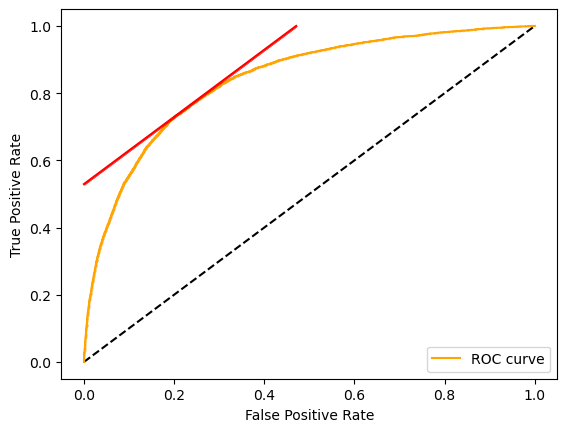

In [15]:
# 38155
symptoms = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
for j in range(test_true.shape[1]):
    if j > 0: break
    plt.plot([0,1], [0,1], linestyle='--', markersize=0.01, color='black')
    fpr, tpr, thresholds = roc_curve(test_true[:,j], test_pred[:,j])
    J = tpr-fpr
    ix = np.argmax(J)
    sens, spec = tpr[ix], 1-fpr[ix]
    plt.plot(fpr, tpr, marker='.', color='orange', markersize=0.05, label='ROC curve')
    
    before_Xs = np.linspace(0,1,len(fpr))
    Xs = before_Xs[before_Xs <= fpr[ix] + 1 - tpr[ix]]
    Ys = Xs-fpr[ix] + tpr[ix]
    
    plt.plot(Xs, Ys, marker='.', color='red', markersize=0.05)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.savefig(os.path.join(os.getcwd(),'plot_files',f'geometric interpretation of J-statistics.jpg'))
    plt.show()